## Jorge Bueno Perez - 419034

## Prediction of the average price of the Spanish rail tickets data 

In [1]:
import numpy as np
import pandas as pd
from ggplot import *
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend" # most important part

import keras
import keras.applications as kapp
from keras.datasets import cifar10

Using plaidml.keras.backend backend.


In [2]:
renfe = pd.read_csv("~/Desktop/Projects/DL/Regression/Before_modeling/Datasets/renfe.csv")

### After the data cleaning we have `10 columns` and `253458 rows`

In [3]:
renfe.head()

,origin,destination,duration,vehicle_type,vehicle_class,fare,price,week_day,month,year,time
0,ALBACETE,MADRID,1.63,AVE,Preferente,Promo,41.35,4,2,2020,21:09
1,ALBACETE,MADRID,2.53,ALTARIA,Turista,Promo,24.80,4,2,2020,21:29
2,ALBACETE,MADRID,2.63,MD,Turista,Adulto ida,31.20,5,2,2020,07:30
3,ALBACETE,MADRID,1.50,AVE,Turista,Promo,31.85,5,2,2020,08:05
4,ALBACETE,MADRID,1.63,AVE,Preferente,Promo,36.65,5,2,2020,09:32


In [4]:
renfe.shape[0] 

253452

# 1) `Columns description`:

## `Origin` - It indicates the departure city 
## `Destination` - It indicates the destination city 
## `Duration` - In indicates the duration of the travel
## `Vehicle type` - It indicates the type of rail - 30 different types of vehicle
## `Vehicle class` - It indicates the class of vehicle - 11 different types of classes
## `Fare` - It idicates the type of fare - 12 different types of fares
## `Price` - It is the average of the scrapped price for each different travel - in euros
## `Week_day`- It indicates the day of the departure, from `Monday= 0`, to `Sunday= 6`
## `Month` - It indicates the month of the departure, `January= 1`, to `December= 12`
## `Year` - It indicates the year of the departure
## `Time` - It indicates the hour and minutes of the departure

# 2) `Checking unique values` and `price description`:

In [5]:
col_names = renfe.columns.values.tolist()

In [6]:
for i in col_names:
    print(str(len(renfe[i].unique())) + " unique values in " + i) 

30 unique values in origin
30 unique values in destination
358 unique values in duration
30 unique values in vehicle_type
11 unique values in vehicle_class
11 unique values in fare
53701 unique values in price
7 unique values in week_day
12 unique values in month
2 unique values in year
522 unique values in time


In [7]:
renfe['price'].describe() 

count    253452.000000
mean         60.133377
std          29.160135
min           5.650000
25%          38.000000
50%          55.700000
75%          76.300000
max         226.400000
Name: price, dtype: float64

# 3) `Creating a map of routes`

### Below we can see how often are the different travels, it seems the most frequent is between the big cities, such as between `Madrid` and `Barcelona`

In [8]:
renfe.filter(['origin', 'destination']).groupby(['origin', 'destination'], as_index=False).size().sort_values(['size'], ascending= False)[:5] 

,origin,destination,size
2,BARCELONA,MADRID,27157
21,MADRID,BARCELONA,26452
53,SEVILLA,MADRID,17346
41,MADRID,SEVILLA,16717
44,MADRID,VALENCIA,16116


In [9]:
route= renfe.filter(['origin', 'destination']).groupby(['origin', 'destination'], as_index=False).size().sort_values(['size'], ascending= False) 
origin= route['origin'].tolist()
destination= route['destination'].tolist()
or_dest_unique= route.origin.unique().tolist()

### The below code extracts the coordinates of the different `origin` and `destination` cities

In [10]:
#import geocoder
#coord = []
#for i in or_dest_unique:
#    g = geocoder.osm(str(i +",  Spain"))
#    coord.extend((str(i), g.osm['y'], g.osm['x']))

with open('coord.txt', 'w') as filehandle:
    for listitem in coord:
        filehandle.write('%s\n' % listitem)

coord = []
with open('coord.txt', 'r') as filehandle:
    for line in filehandle:
        currentPlace = line[:-1]
        coord.append(currentPlace)

In [3]:
coord = pd.read_csv("~/Desktop/Projects/DL/Regression/Before_modeling/Others/coord.csv")

In [12]:
coord = coord["0"].tolist()

### The below function creates `four columns` according to the `origin` and `destination`:
- `Origin`: `origin_lng` (longitude) and `origin_lat` (latitude)
- `Destination`: `destination_lng` (longitude) and`destination_lat` (latitude)

In [13]:
df = pd.DataFrame(columns = ['origin_lng', 'origin_lat', 'destination_lng', 'destination_lat'])
for i in range(len(origin)):
    s = []
    if origin[i] in coord:
        s.append(coord[coord.index(origin[i]) + 1])
        s.append(coord[coord.index(origin[i]) + 2])
    if destination[i] in coord:
        s.append(coord[coord.index(destination[i]) + 1])
        s.append(coord[coord.index(destination[i]) + 2])
    df.loc[i] = s
for i in df.columns.tolist():
    df[str(i)] = pd.to_numeric(df[str(i)])

### After that we can `create the map` with the help of the package `folium`

In [14]:
import folium
centroid_lat = 40.2085 
centroid_lon = -3.7130
m = folium.Map([centroid_lat, centroid_lon], zoom_start=6)
for i in range(len(df)):
    folium.CircleMarker(df.iloc[i][:2].tolist(),
                        radius=15,
                        fill_color="blue", 
                       ).add_child(folium.Popup(str(destination[i]))).add_to(m) # destination

    folium.CircleMarker(df.iloc[i][:2].tolist(),
                        radius=15,
                        fill_color="red", 
                       ).add_child(folium.Popup(str(origin[i]))).add_to(m) # origin

    folium.PolyLine([df.iloc[i][2:].tolist(), df.iloc[i][:2].tolist()],
               color="red").add_to(m)

m

In [15]:
m.save('~/Desktop/Projects/DL/Regression/Before_modeling/Figures/map.html')

In [16]:
df['origin'] = origin
df['destination'] = destination
df.to_csv("~/Desktop/Projects/DL/Regression/Before_modeling/Others/coord_city.csv", index=False)

# 4)`Graphical representation` of the rest of the features:

### Four graphs are going to be created for the rest of categorical colummns, but also `time`will be included 

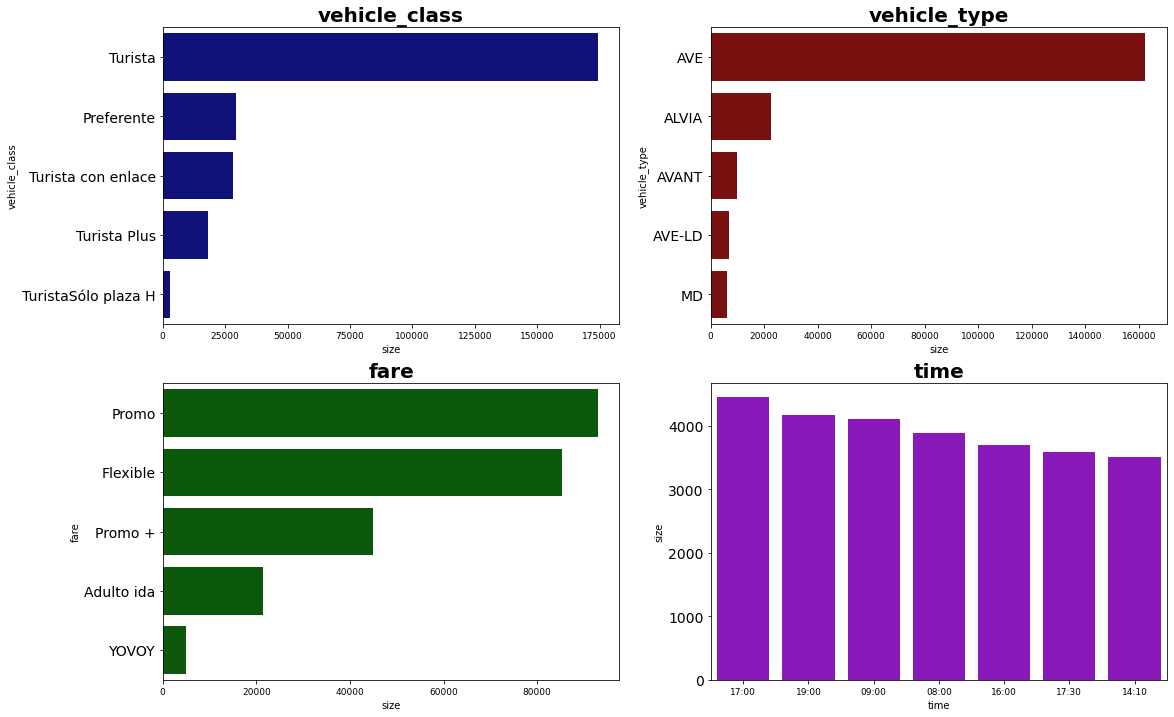

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax =plt.subplots(2,2, figsize=(18,12))
ax = ax.flatten()

col_list= ["vehicle_class", "vehicle_type", "fare"]
color_list= ["darkblue", "darkred", "darkgreen"]

r = 0
for i in col_list:
    df= renfe.filter([i]).groupby([i], as_index=False).size().sort_values(['size'], ascending= False)[:5].sort_values("size", ascending=False)

    plot = sns.barplot(x="size", y=str(i), data=df,
            label="Total", color=str(color_list[r]), ax=ax[r])
    plot.set_title(str(i), fontsize=20, fontweight="bold")
    plot.tick_params(axis='x', labelsize=9)
    plot.tick_params(axis='y', labelsize=14)
    r += 1
df= renfe.filter(["time"]).groupby(["time"], as_index=False).size().sort_values(['size'], ascending= False)[:7].sort_values("size", ascending=False)

plot = sns.barplot(x="time", y=str("size"), data=df,
            label="Total", color= "darkviolet", ax=ax[3])
plot.set_title("time", fontsize=20, fontweight="bold")
plot.tick_params(axis='x', labelsize=9)
plot.tick_params(axis='y', labelsize=14)
fig.savefig('~/Desktop/Projects/DL/Regression/Before_modeling/Figures/plot_types.png')

### We can observe the following:
- `Turista` is the most common class in `vehicle_class`
- `AVE` is the most repeated `vehicle_type`
- `Promo` is the most frequent `fare`
-  `5 pm` is the most popular `time of departure` for the trains 

### The target variable `price` will be represented as a `density plot`

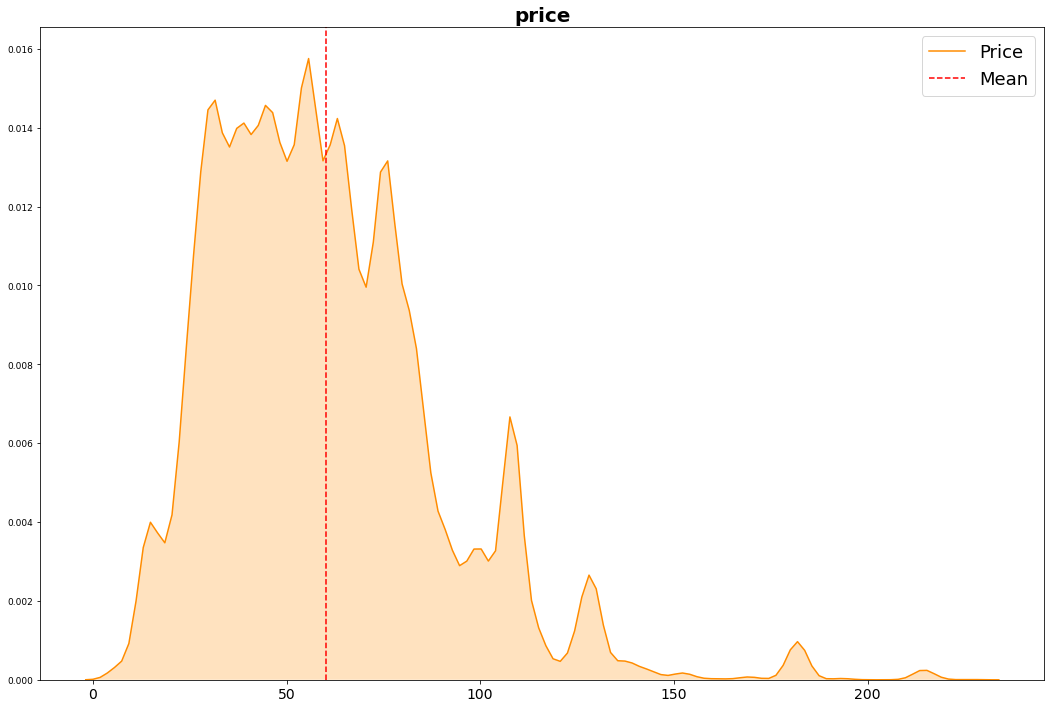

In [18]:
fig, ax =plt.subplots(figsize=(18,12))
plot = sns.kdeplot(renfe['price'], shade=True, color="darkorange")
plot.tick_params(axis='x', labelsize=14)
plot.tick_params(axis='y', labelsize=9)
plot.set_title("price", fontsize=20, fontweight="bold")
plot.axvline(renfe.price.mean(), color='r', linestyle='--')
plt.legend({'Price': renfe.price, 'Mean':renfe.price.mean()}, fontsize=18)
plt.show()
fig.savefig('~/Desktop/Projects/DL/Regression/Before_modeling/Figures/plot_price.png')

### The `rest of the numerical variables` are going to be ploted

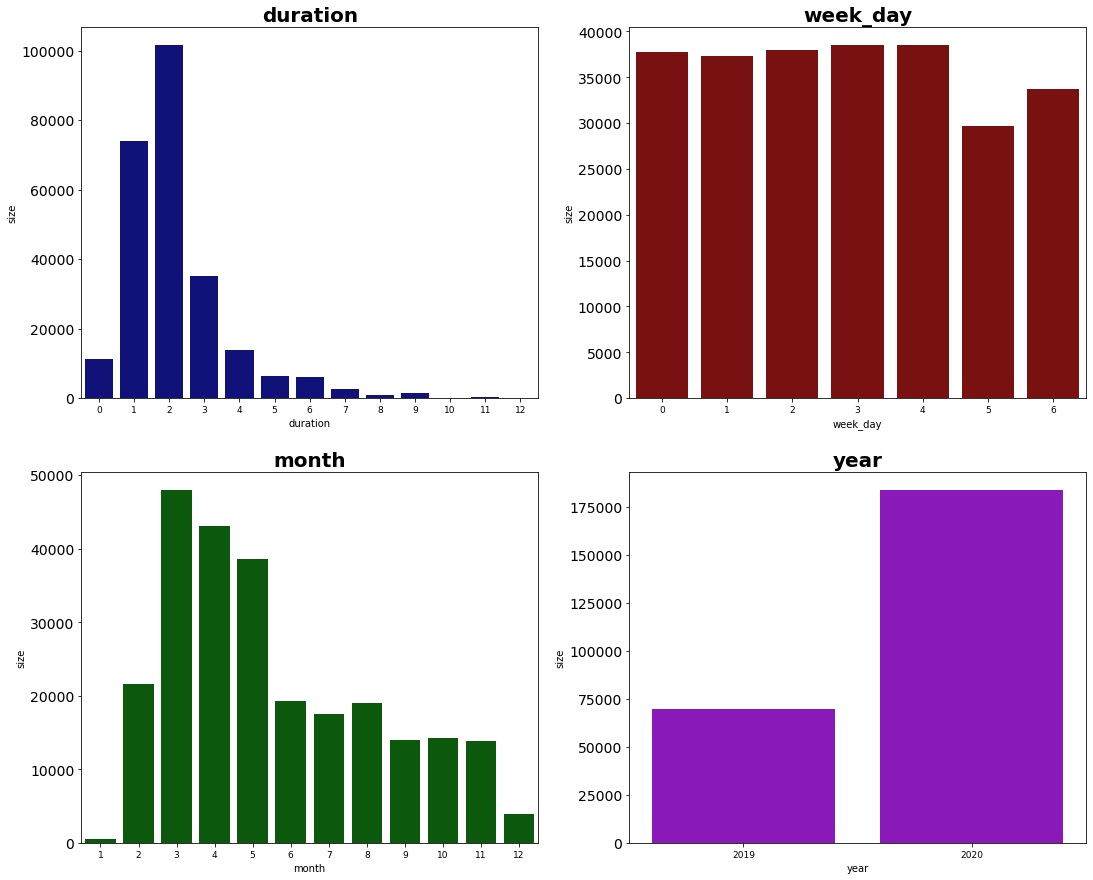

In [19]:
renfe['week_day'] = renfe['week_day'].astype(int)
renfe['month'] = renfe['month'].astype(int)
renfe['year'] = renfe['year'].astype(int)
renfe['duration'] = renfe['duration'].astype(int)
renfe_time = pd.DataFrame()
fig, ax =plt.subplots(2,2, figsize=(18, 15))
ax = ax.flatten()
col_list= ["duration", "week_day", "month", "year"]
color_list= ["darkblue", "darkred", "darkgreen", "darkviolet"]

r = 0
for i in col_list:
    df= renfe.filter([i]).groupby([i], as_index=False).size().sort_values([i], ascending= False)

    plot = sns.barplot(y="size", x=str(i), data=df,
            label="Total", color=str(color_list[r]), ax=ax[r])
    plot.set_title(str(i), fontsize=20, fontweight="bold")
    plot.tick_params(axis='x', labelsize=9)
    plot.tick_params(axis='y', labelsize=14)
    r += 1
fig.savefig('~/Desktop/Projects/DL/Regression/Before_modeling/Figures/plot_time.png')

### We can observe the following:
- `2 hours`is the most common `duration` of the travel
- On `Saturdays` there are less trains
- In `March` there was the highest number of trains
- In the dataset there are more travels that belongs to the year `2020`

In [20]:
#renfe.to_csv("~/Desktop/Projects/DL/Regression/Before_modeling/Datasets/renfe1.csv", index=False)